## Can active learning preemptively mitigate fairness issues?
*By Parmida Atighehchian*

The purpose of this notebook is to demonstrate the prilimary results of our recent [contribution](https://arxiv.org/abs/2104.06879) to ICLR workshop of Responsible AI 2021.
We show that active learning could help in creating fairer datasets without the need to know the bias in the dataset. This is important since in real scenarios, the source of bias is often unknown. Using active learning (i.e. BALD), we show that the prior knowledge of the bias is not necessary and hence it could be easier to integrate this setup in pipelines to make sure that the dataset is generally fairer and the possible biases are reduced. 

For the purpose of this demo, we use [synbols](https://github.com/ElementAI/synbols) dataset. Synbols is the new state of the art for fast generating of synthetic datasets.

In order to have requirements of this notebook installed, you would need to run the notebook in using the dockerfile located in `baal/docs/notebooks/notebook_support/Docker_biased_data`.

More resources on BaaL:
* [Literature review](https://baal.readthedocs.io/en/latest/literature/index.html)
* [Active learning dataset and training loop classes](https://baal.readthedocs.io/en/latest/notebooks/fundamentals/active-learning.html)
* [Methods for approximating bayesian posteriors](https://baal.readthedocs.io/en/latest/notebooks/fundamentals/posteriors.html)
* [Full active learning example](https://baal.readthedocs.io/en/latest/notebooks/active_learning_process.html)

### Introducing bias in dataset
We introduce bias in dataset using color. For this purpose, we create a set of `a` and `d` letters with different fonts and shapes, however majority of `a` letters is red and majority of `d` letters is blue. We would like to see if active learning help in removing/reducing this bias.


In [1]:
import numpy as np
from math import pi
from synbols.data_io import pack_dataset
from synbols import drawing
from synbols import generate

class InfoSolid(drawing.SolidColor):
    def attribute_dict(self):
        d = super().attribute_dict()
        d['color'] = self.color
        return d
    
rng = np.random.RandomState(1337)
p = .1
blue = (0,0,255)
red = (255, 0, 0)

class SpuriousSampler:
    def __init__(self, p):
        self.p = p
        
    def __call__(self, seed):
        """Makes color dependant on symbol."""
        rng = np.random.RandomState(seed)
        color = [blue, red][rng.choice([0, 1], p=[self.p, 1-self.p])]
        char = rng.choice(['a', 'd'])
        color_p = {'a':self.p, 'd':1-self.p}[char]
        color = [blue, red][rng.choice([0, 1], p=[color_p, 1-color_p])]

        fg = InfoSolid(color)
        fg.color = color

        attr_sampler = generate.basic_attribute_sampler(
            char=char, foreground=fg, background=None, inverse_color=False, resolution=(64, 64))
        d = attr_sampler()
        return d


def make_dataset(p, seed, num):
    attribute_sampler = SpuriousSampler(p=p)
    x, mask, y = pack_dataset(generate.dataset_generator(attribute_sampler, num, generate.flatten_mask, dataset_seed=seed))
    for yi in y:
        yi['color'] = 'red' if yi['foreground']['color'] == red else 'blue'
    return (x,y,y)             

train_set = make_dataset(p=0.9, seed=1000, num=10000)
test_set = make_dataset(p=0.5, seed=2000, num=5000)
dataset = {'train': train_set, 'test': test_set}

100%|██████████| 5000/5000 [01:13<00:00, 68.07it/s]


### Prepare model and dataset to be used in BaaL setup
As usual we wrap the train_set in `ActiveLearningDataset` and using vgg16 as default model, we use the BaaL's `patch_module` to create a dropout layer which performs in inference time.

In [3]:
from torchvision.transforms import transforms
from active_fairness.dataset import SynbolDataset
from baal.active import get_heuristic, ActiveLearningDataset
from typing import Dict

IMG_SIZE=64

def get_datasets(dataset : Dict, initial_pool: int, attribute:str, target_key:str):
    """
    Get the dataset for the experiment.
    Args:
        dataset: The synbol generated dataset.
        initial_pool: Initial number of items to label.
        attribute: Key where the sensitive attribute is.
        target_key: Key where the target is.
    Returns:
        ActiveLearningDataset with `initial_pool` items labelled
        Test dataset
    """
    transform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize((IMG_SIZE, IMG_SIZE)),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(30),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    test_transform = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                              (0.2023, 0.1994, 0.2010))])
    train_ds = dataset['train']
    test_ds = dataset['test']
    ds = SynbolDataset(*train_ds, target_key=target_key, attribute=attribute,
                           transform=transform)

    test_set = SynbolDataset(*test_ds, target_key=target_key, attribute=attribute,
                                 transform=test_transform)

    active_set = ActiveLearningDataset(ds, pool_specifics={'transform': test_transform})
    active_set.label_randomly(initial_pool)
    return active_set, test_set

In [4]:
from torchvision import models
from torch.hub import load_state_dict_from_url
from baal.bayesian.dropout import patch_module

#set use_cuda to False if you don't have access to GPUS
use_cuda=True

model = models.vgg16(pretrained=False, num_classes=2)
weights = load_state_dict_from_url('https://download.pytorch.org/models/vgg16-397923af.pth')
weights = {k: v for k, v in weights.items() if 'classifier.6' not in k}
model.load_state_dict(weights, strict=False)

# change dropout layer to MCDropout
model = patch_module(model)

if use_cuda:
    model.cuda()


We wrap the pytorch criterion to accomodate target being a dictionary.

In [5]:
from torch import nn

class Criterion(nn.Module):
    def __init__(self, crit):
        super().__init__()
        self.crit = crit

    def forward(self, input, target):
        return self.crit(input, target['target'])

Let's now train the model with active learning. As usual, we compare `bald` with `random` but this time, we are looking for something else in the results!

In [ ]:
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import torch
from torch import optim
from torch.nn import CrossEntropyLoss
from baal.modelwrapper import ModelWrapper
from baal.active.heuristics import BALD
from baal.active.active_loop import ActiveLearningLoop
from active_fairness.metrics import FairnessMetric
import sklearn.metrics as skm

heuristics = ['bald', 'random']

logs = {'bald': {}, 'random': {}}

for heuristic_name in heuristics:
    active_set, test_set = get_datasets(dataset, initial_pool=500, attribute='color', target_key='char')

    heuristic = get_heuristic(name=heuristic_name, shuffle_prop=0.0)

    criterion = Criterion(CrossEntropyLoss())

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

    wrapped_model = ModelWrapper(model, criterion)

    wrapped_model.add_metric('aggregate_res', lambda: FairnessMetric(skm.accuracy_score, name='acc',
                                                                     attribute='color'))

    # save imagenet weights
    init_weights = deepcopy(model.state_dict())


    bald = BALD()



    # for prediction we use a smaller batchsize
    # since it is slower
    active_loop = ActiveLearningLoop(active_set,
                                     wrapped_model.predict_on_dataset,
                                     heuristic,
                                     50,
                                     batch_size=16,
                                     iterations=20,
                                     use_cuda=use_cuda,
                                     workers=0)
    learning_epoch = 20
    for epoch in tqdm(range(100000)):
        wrapped_model.load_state_dict(init_weights)
        wrapped_model.train_on_dataset(active_set, optimizer, batch_size=32,
                                       epoch=learning_epoch, use_cuda=True, workers=12)

        # Validation!
        wrapped_model.test_on_dataset(test_set, batch_size=32, use_cuda=use_cuda,
                                      workers=12, average_predictions=20)

        should_continue = active_loop.step()
        if not should_continue:
            break

        # Send logs
        fair_train = wrapped_model.metrics[f'train_aggregate_res'].value
        epoch_logs = {
            'epoch': epoch,
            'test_loss': wrapped_model.metrics['test_loss'].value,
            'active_train_size': len(active_set)}

        agg_res = {'train_' + k: v for k, v in fair_train.items()}
        epoch_logs.update(agg_res)

        for k, v in epoch_logs.items():
            if k in logs[heuristic_name].keys():
                logs[heuristic_name][k].append(v)
            else:
                logs[heuristic_name][k] = [v]

        if len(active_set) > 2000:
            break


  0%|          | 0/100000 [00:00<?, ?it/s]

[30-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-15T17:30:09.572527Z [info     ] Starting training              dataset=500 epoch=20
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-15T17:31:22.184922Z [info     ] Training complete              train_loss=0.050071753561496735
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-15T17:31:22.187028Z [info     ] Starting evaluating            dataset=5000
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-15T17:31:49.089488Z [info     ] Evaluation complete            test_loss=0.8750974535942078
[30-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-15T17:31:49.169282Z [info     ] Start Predict                  dataset=9500

100%|██████████| 594/594 [01:20<00:00,  7.42it/s]

Supplied 'func' had no __name__ attribute



Overall acc =  0.982
acc by groups =  [('blue', 0.981203007518797), ('red', 0.9829059829059829)]
acc ratio =  0.9982674076495587
acc diff =  0.00170297538718589


  0%|          | 1/100000 [02:59<4992:28:06, 179.73s/it]

[30-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-15T17:33:09.304288Z [info     ] Starting training              dataset=550 epoch=20
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-15T17:34:30.078231Z [info     ] Training complete              train_loss=0.03657064214348793
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-15T17:34:30.080179Z [info     ] Starting evaluating            dataset=5000
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-15T17:34:57.085626Z [info     ] Evaluation complete            test_loss=0.8824235200881958
[30-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-15T17:34:57.170399Z [info     ] Start Predict                  dataset=9450

100%|██████████| 591/591 [01:18<00:00,  7.58it/s]


Supplied 'func' had no __name__ attribute
  0%|          | 2/100000 [06:05<5044:23:12, 181.60s/it]

Overall acc =  0.9890909090909091
acc by groups =  [('blue', 0.9873015873015873), ('red', 0.9914893617021276)]
acc ratio =  0.9957762790380816
acc diff =  0.004187774400540301
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-15T17:36:15.271134Z [info     ] Starting training              dataset=600 epoch=20
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-15T17:37:30.489540Z [info     ] Training complete              train_loss=0.10447773337364197
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-15T17:37:30.566633Z [info     ] Starting evaluating            dataset=5000
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-15T17:37:56.681052Z [info     ] Evaluation complete            test_loss=0.42347872257232666
[30-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-15T17:37:56.685886Z [info     ] Start Predict                  dataset=9400

100%|██████████| 588/588 [01:15<00:00,  7.82it/s]


Supplied 'func' had no __name__ attribute
  0%|          | 3/100000 [09:02<5003:20:46, 180.13s/it]

Overall acc =  0.96
acc by groups =  [('blue', 0.9622641509433962), ('red', 0.9574468085106383)]
acc ratio =  0.9949937421777222
acc diff =  0.004817342432757887
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-15T17:39:11.953584Z [info     ] Starting training              dataset=650 epoch=20
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-15T17:40:29.675053Z [info     ] Training complete              train_loss=0.0808490514755249
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-15T17:40:29.676914Z [info     ] Starting evaluating            dataset=5000
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-15T17:40:55.976888Z [info     ] Evaluation complete            test_loss=0.5092220306396484
[30-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-15T17:40:55.981874Z [info     ] Start Predict                  dataset=9350

100%|██████████| 585/585 [01:16<00:00,  7.62it/s]


Supplied 'func' had no __name__ attribute
  0%|          | 4/100000 [12:03<5009:54:27, 180.36s/it]

Overall acc =  0.9723076923076923
acc by groups =  [('blue', 0.9721362229102167), ('red', 0.9724770642201835)]
acc ratio =  0.9996495122378644
acc diff =  0.0003408413099668106
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-15T17:42:12.872856Z [info     ] Starting training              dataset=700 epoch=20
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-15T17:43:33.181010Z [info     ] Training complete              train_loss=0.10487625747919083
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-15T17:43:33.182921Z [info     ] Starting evaluating            dataset=5000
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-15T17:43:59.479583Z [info     ] Evaluation complete            test_loss=0.466669499874115
[30-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-15T17:43:59.484577Z [info     ] Start Predict                  dataset=9300

100%|██████████| 582/582 [01:16<00:00,  7.64it/s]

Supplied 'func' had no __name__ attribute


  0%|          | 5/100000 [15:06<5030:47:09, 181.12s/it]

Overall acc =  0.9657142857142857
acc by groups =  [('blue', 0.977961432506887), ('red', 0.9525222551928784)]
acc ratio =  0.9739875454507461
acc diff =  0.025439177314008687
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-15T17:45:15.748756Z [info     ] Starting training              dataset=750 epoch=20
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-15T17:46:42.180792Z [info     ] Training complete              train_loss=0.05256995931267738
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-15T17:46:42.182686Z [info     ] Starting evaluating            dataset=5000
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-15T17:47:08.608520Z [info     ] Evaluation complete            test_loss=0.35186535120010376
[30-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-15T17:47:08.668856Z [info     ] Start Predict                  dataset=9250

100%|██████████| 579/579 [01:16<00:00,  7.55it/s]


Supplied 'func' had no __name__ attribute
  0%|          | 6/100000 [18:15<5102:38:57, 183.71s/it]

Overall acc =  0.984
acc by groups =  [('blue', 0.9761904761904762), ('red', 0.9919354838709677)]
acc ratio =  0.9841269841269841
acc diff =  0.015745007680491585
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-15T17:48:25.496165Z [info     ] Starting training              dataset=800 epoch=20
[30-MainThread   ] [baal.modelwrapper:train_on_dataset:119] 2021-06-15T17:49:53.995112Z [info     ] Training complete              train_loss=0.06759453564882278
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:147] 2021-06-15T17:49:53.997182Z [info     ] Starting evaluating            dataset=5000
[30-MainThread   ] [baal.modelwrapper:test_on_dataset:156] 2021-06-15T17:50:20.677256Z [info     ] Evaluation complete            test_loss=0.3287539780139923
[30-MainThread   ] [baal.modelwrapper:predict_on_dataset_generator:239] 2021-06-15T17:50:20.682384Z [info     ] Start Predict                  dataset=9200

100%|██████████| 575/575 [01:14<00:00,  7.75it/s]

Supplied 'func' had no __name__ attribute



Overall acc =  0.9675
acc by groups =  [('blue', 0.9662337662337662), ('red', 0.9686746987951808)]
acc ratio =  0.9974801318084899
acc diff =  0.0024409325614145327


  0%|          | 7/100000 [21:25<5151:03:19, 185.45s/it]

[30-MainThread   ] [baal.modelwrapper:train_on_dataset:109] 2021-06-15T17:51:35.017451Z [info     ] Starting training              dataset=850 epoch=20


## Results and Discussion
Below we show the number of samples added to each subcategory (i.e. character with a specific color) as the training goes on. Interesting result is that the number of samples added to the minority group of each character increases using `bald` where as `random` picks samples in a random setup and hence having more samples given a protected attribute (here color), random has more samples of a certain color to pick. This indicates that active learning with `bald` generally leads to a more fair dataset.

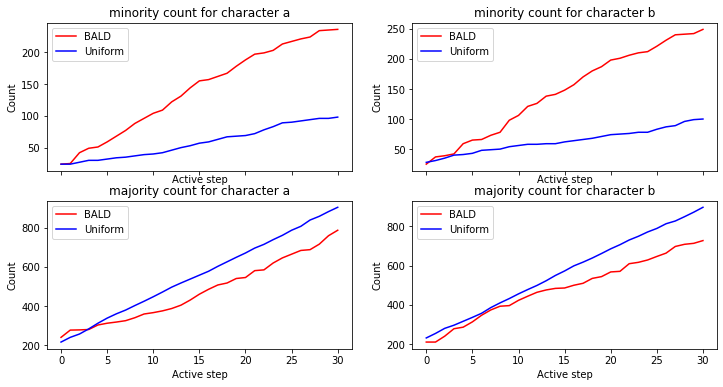

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline


x = logs['bald']['epoch']
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, sharex=True,
                                    figsize=(12, 6))
plots_target = [('minority count for character a', 'train_count_0_red'),
                 ('minority count for character b', 'train_count_1_blue'),
               ('majority count for character a', 'train_count_0_blue'),
               ('majority count for character b', 'train_count_1_red')]

for ax, (title, key) in zip([ax0, ax1, ax2, ax3], plots_target):
    ax.set_title(title)
    ax.plot(x, logs['bald'][key], color='r', label="BALD")
    ax.plot(x, logs['random'][key], color='b', label="Uniform")
    ax.set_xlabel('Active step')
    ax.set_ylabel('Count')
    ax.legend()

fig.show()

We demonstrate the `test_loss` and `training_size` using `bald` vs `random` as heuristics. As it is shown, the trainig size increases with the same pace but the above graphs shows the underlying difference in the existing samples for each class which then results in also a better loss decrease using `bald`.

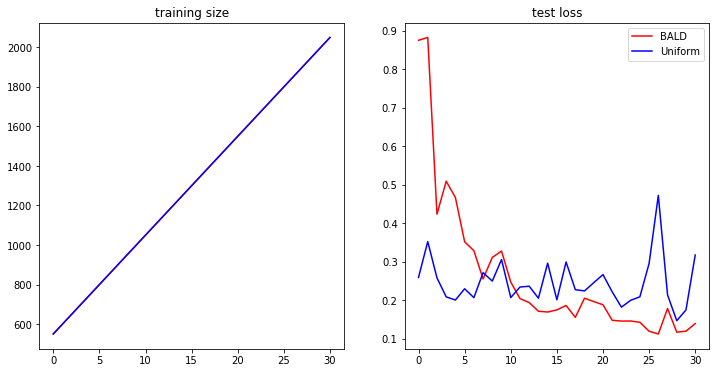

In [16]:
x = logs['bald']['epoch']
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                    figsize=(12, 6))
ax0.set_title('training size')
ax0.plot(x, logs['bald']['active_train_size'], color='r', label='BALD')
ax0.plot(x, logs['random']['active_train_size'], color='b', label='Uniform')

ax1.set_title('test loss')
ax1.plot(x, logs['bald']['test_loss'], color='r', label='BALD')
ax1.plot(x, logs['random']['test_loss'], color='b', label='Uniform')
ax1.legend()
fig.show()